# Model Search - k Best Features

In this notebook we will continue the model evaluation process, introducing a preprocessing step to reduce the number of features that we use to train our models.  Fewer features mean faster model training (this probably isn't a huge issue for us) and can also improve accuracy by removing irrelavent noise from our input space.

In [1]:
# get the data and resample
import ml_utils as mu

# get the training data
data = mu.get_training_data()
X, y = mu.split_x_and_y(data)

# get the holdout and outside validation data
Xh, yh = mu.split_x_and_y(mu.get_holdout_data())
Xh, yh = mu.resample_to_equal_class_sizes(Xh, yh)

Xv, yv = mu.split_x_and_y(mu.get_validation_data())
Xv, yv = mu.resample_to_equal_class_sizes(Xv, yv)

Maximum class size is 80
Class 0 size is 48. Resampling with replacement to 80
Class 1 size has max class size (80).
Class 2 size is 11. Resampling with replacement to 80
Class 3 size is 11. Resampling with replacement to 80
Maximum class size is 32
Class 0 size is 6. Resampling with replacement to 32
Class 1 size has max class size (32).
Class 2 size is 4. Resampling with replacement to 32
Class 3 size is 8. Resampling with replacement to 32


## Iterative k-Best Feature Selection using ANOVA F-Score

[2018-06-29 23:04:20.422863] Starting knn
[2018-06-29 23:04:23.917231] Done with knn (Took 0.058 minutes minutes)
[2018-06-29 23:04:23.946233] Starting svc_lin
[2018-06-29 23:04:30.376609] Done with svc_lin (Took 0.107 minutes minutes)
[2018-06-29 23:04:30.403670] Starting svc_rbf
[2018-06-29 23:04:45.335014] Done with svc_rbf (Took 0.249 minutes minutes)
[2018-06-29 23:04:45.376995] Starting rand_for
[2018-06-29 23:04:51.927841] Done with rand_for (Took 0.109 minutes minutes)
[2018-06-29 23:04:51.964406] Starting ada
[2018-06-29 23:05:28.061117] Done with ada (Took 0.602 minutes minutes)
[2018-06-29 23:05:28.089116] Starting gnb
[2018-06-29 23:05:29.779391] Done with gnb (Took 0.028 minutes minutes)
[2018-06-29 23:05:29.818460] Starting log
[2018-06-29 23:05:36.385016] Done with log (Took 0.109 minutes minutes)
[2018-06-29 23:05:36.425028] Starting ann
[2018-06-29 23:07:17.999581] Done with ann (Took 1.693 minutes minutes)


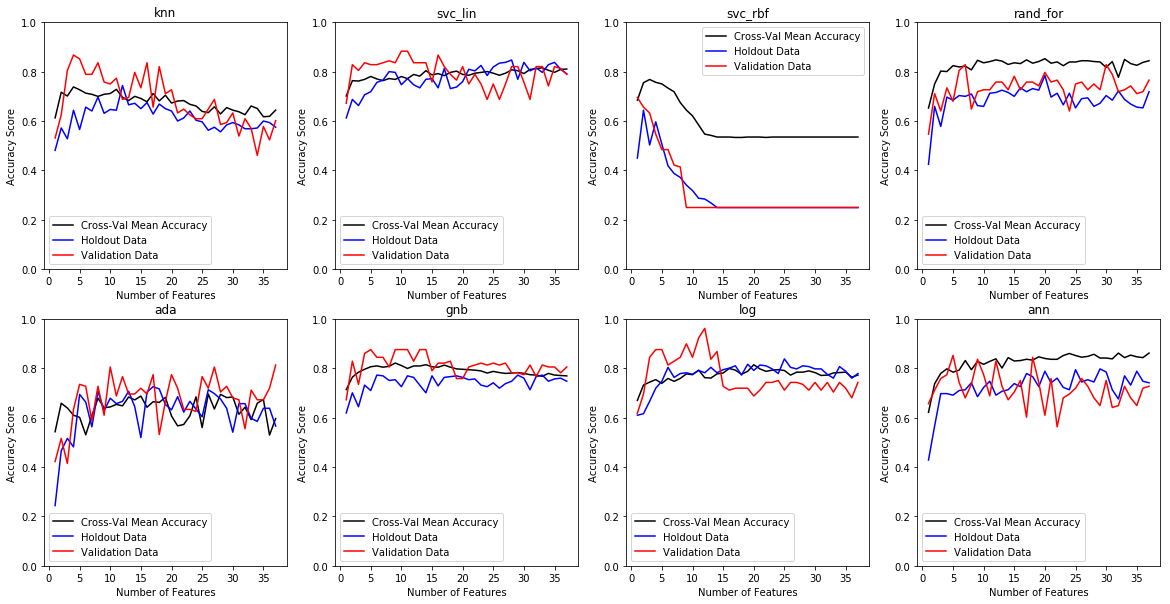

,mean_cv_acc,bestK,mean_bestK_cv_acc,holdout_bestK_acc,valid_bestK_acc
knn,0.632565,3,0.738175,0.64375,0.867188
svc_lin,0.810486,32,0.815444,0.796875,0.820312
svc_rbf,0.53527,2,0.768194,0.503125,0.632812
rand_for,0.834115,19,0.852419,0.784375,0.796875
ada,0.635261,25,0.69521,0.7125,0.71875
gnb,0.773576,8,0.820655,0.753125,0.875
log,0.76513,19,0.813694,0.790625,0.6875
ann,0.852636,31,0.860928,0.675,0.648438


In [2]:
import sys, os
import datetime
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from matplotlib import pyplot as plt
from IPython.display import display

classifiers = mu.get_baseline_models()
df = pd.DataFrame(columns=['mean_cv_acc', 'bestK', 'mean_bestK_cv_acc', 'holdout_bestK_acc', 'valid_bestK_acc'], index=[clf['name'] for clf in classifiers])
fig = plt.figure(figsize=(20,10))

for index, clf in enumerate(classifiers):
    model = clf['model']
    name = clf['name']
    
    start = time.time()
    print("[%s] Starting %s" %(datetime.datetime.now(), name))

    # Run through all possible number of features and save the classifier, test data score and validation data scores
    cross_val_scores = []
    holdout_data_scores = []
    valid_data_scores = []

    # Without k-best
    pipeline = Pipeline([
        ('standardize', StandardScaler()),
        ('oversample', RandomOverSampler()),
        ('classifier', model)
    ])

    cross_val_acc = cross_val_score(pipeline, X, y, cv=StratifiedKFold(5)).mean()
    df.loc[name]['mean_cv_acc'] = cross_val_acc 
    
    ks = range(1, X.shape[1]+1)
    for k in ks:
        sys.stdout.write("\rStarting K-Best with %d features (of %d)" %(k, X.shape[1]))
        sys.stdout.flush()
        
        # With k-best
        pipelineK = Pipeline([
            ('standardize', StandardScaler()),
            ('oversample', RandomOverSampler()),
            ('kbest', SelectKBest(score_func=f_classif, k=k)),
            ('classifier', model)
        ])
        
        cross_val_acc = cross_val_score(pipelineK, X, y, cv=StratifiedKFold(5)).mean()
        
        #train a model with all of the X data
        pipelineK.fit(X,y)
        
        cross_val_scores.append(cross_val_acc)
        holdout_data_scores.append(pipelineK.score(Xh,yh))
        valid_data_scores.append(pipelineK.score(Xv, yv))
    
    end = time.time()
    time_elapsed = "%.3f minutes" %((end-start)/60)
    sys.stdout.write("\r[%s] Done with %s (Took %s minutes)" %(datetime.datetime.now(),name, time_elapsed))
    sys.stdout.flush()
    print()
    
    # Figure out which k yielded the highest mean cross-validation accuracy
    bestK = np.argmax(cross_val_scores)
    
    # Store the 
    df.loc[name]['bestK'] = bestK+1
    df.loc[name]['mean_bestK_cv_acc'] = cross_val_scores[bestK]
    df.loc[name]['holdout_bestK_acc'] = holdout_data_scores[bestK]
    df.loc[name]['valid_bestK_acc'] = valid_data_scores[bestK]

    plt.subplot(2, 4,index+1)
    plt.plot(ks, cross_val_scores, color='black', label='Cross-Val Mean Accuracy')
    plt.plot(ks, holdout_data_scores, color='blue', label='Holdout Data')
    plt.plot(ks, valid_data_scores, color='red', label='Validation Data')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy Score')
    plt.ylim([0,1])
    plt.title(name)
    plt.legend()
    
plt.show()
fig.savefig('images/kBest_fscore.png')
df1 = df.copy()
display(df1)

In [21]:
df1['mean_cv_acc'] - df['']

,mean_cv_acc,bestK,mean_bestK_cv_acc,holdout_bestK_acc,valid_bestK_acc
knn,0.632565,3,0.738175,0.64375,0.867188
svc_lin,0.810486,32,0.815444,0.796875,0.820312
svc_rbf,0.53527,2,0.768194,0.503125,0.632812
rand_for,0.834115,19,0.852419,0.784375,0.796875
ada,0.635261,25,0.69521,0.7125,0.71875
gnb,0.773576,8,0.820655,0.753125,0.875
log,0.76513,19,0.813694,0.790625,0.6875
ann,0.852636,31,0.860928,0.675,0.648438


In [20]:
df1.loc[:,['bestK']]

,bestK
knn,3
svc_lin,32
svc_rbf,2
rand_for,19
ada,25
gnb,8
log,19
ann,31


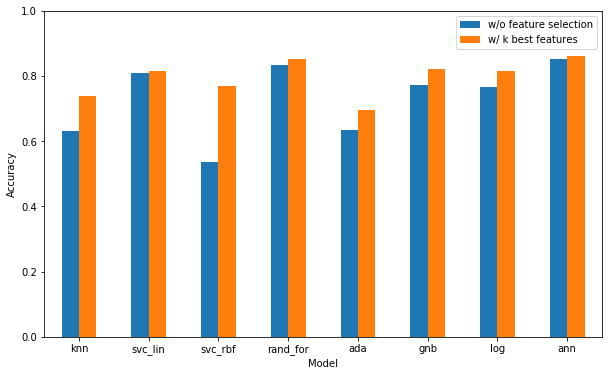

In [13]:
%matplotlib inline
ax = df1.drop(['bestK', 'holdout_bestK_acc', 'valid_bestK_acc'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1))
l = ax.legend(labels=['w/o feature selection', 'w/ k best features'])
fig = ax.get_figure()
fig.savefig('images/feature_subset_acc_fscore.png')

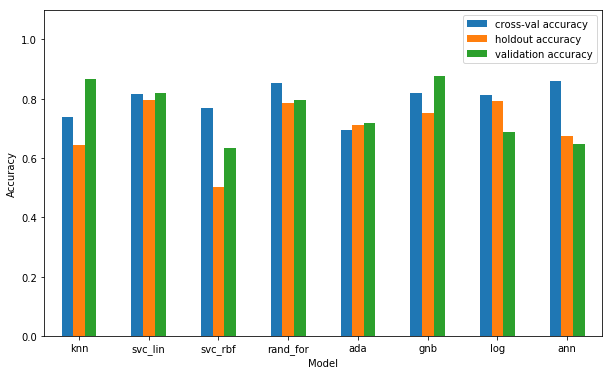

In [9]:
%matplotlib inline
ax = df1.drop(['mean_cv_acc', 'bestK'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1.1))
l = ax.legend(labels=['cross-val accuracy','holdout accuracy', 'validation accuracy'])
fig = ax.get_figure()
fig.savefig('images/fss_validation_fscore.png')

## Iterative k-Best Feature Selection using Mutual Information

[2018-06-29 23:07:19.748592] Starting knn
[2018-06-29 23:08:52.852947] Done with knn (Took 1.552 minutes minutes)
[2018-06-29 23:08:52.889512] Starting svc_lin
[2018-06-29 23:10:29.188899] Done with svc_lin (Took 1.605 minutes minutes)
[2018-06-29 23:10:29.248941] Starting svc_rbf
[2018-06-29 23:12:11.136346] Done with svc_rbf (Took 1.698 minutes minutes)
[2018-06-29 23:12:11.163327] Starting rand_for
[2018-06-29 23:13:46.347489] Done with rand_for (Took 1.586 minutes minutes)
[2018-06-29 23:13:46.374522] Starting ada
[2018-06-29 23:15:50.989118] Done with ada (Took 2.077 minutes minutes)
[2018-06-29 23:15:51.015121] Starting gnb
[2018-06-29 23:17:28.235364] Done with gnb (Took 1.620 minutes minutes)
[2018-06-29 23:17:28.271328] Starting log
[2018-06-29 23:19:02.283489] Done with log (Took 1.567 minutes minutes)
[2018-06-29 23:19:02.326997] Starting ann
[2018-06-29 23:22:25.317858] Done with ann (Took 3.383 minutes minutes)


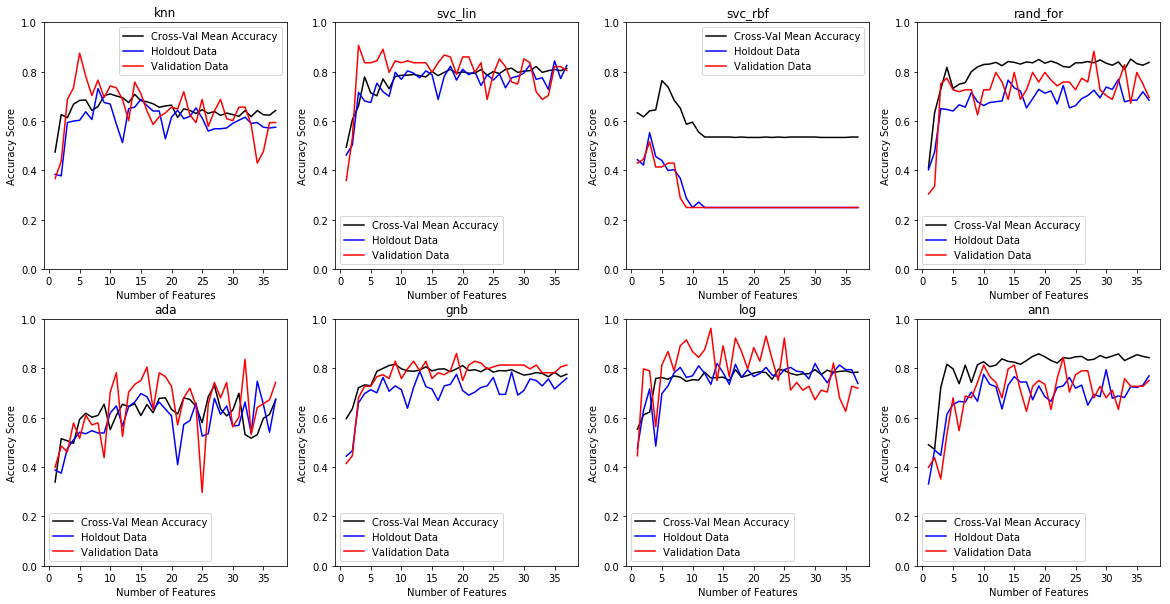

,mean_cv_acc,bestK,mean_bestK_cv_acc,holdout_bestK_acc,valid_bestK_acc
knn,0.642564,9,0.709801,0.66875,0.742188
svc_lin,0.802111,31,0.820545,0.76875,0.71875
svc_rbf,0.53527,4,0.763493,0.440625,0.414062
rand_for,0.847479,33,0.850854,0.684375,0.671875
ada,0.624143,26,0.730015,0.678125,0.742188
gnb,0.760115,8,0.81554,0.728125,0.828125
log,0.773633,23,0.795458,0.765625,0.75
ann,0.850771,18,0.857848,0.728125,0.75


In [5]:
import sys, os
import datetime
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from matplotlib import pyplot as plt
from IPython.display import display

classifiers = mu.get_baseline_models()
df = pd.DataFrame(columns=['mean_cv_acc', 'bestK', 'mean_bestK_cv_acc', 'holdout_bestK_acc', 'valid_bestK_acc'], index=[clf['name'] for clf in classifiers])
fig = plt.figure(figsize=(20,10))

for index, clf in enumerate(classifiers):
    model = clf['model']
    name = clf['name']
    
    start = time.time()
    print("[%s] Starting %s" %(datetime.datetime.now(), name))

    # Run through all possible number of features and save the classifier, test data score and validation data scores
    cross_val_scores = []
    holdout_data_scores = []
    valid_data_scores = []

    # Without k-best
    pipeline = Pipeline([
        ('standardize', StandardScaler()),
        ('oversample', RandomOverSampler()),
        ('classifier', model)
    ])

    cross_val_acc = cross_val_score(pipeline, X, y, cv=StratifiedKFold(5)).mean()
    df.loc[name]['mean_cv_acc'] = cross_val_acc 
    
    ks = range(1, X.shape[1]+1)
    for k in ks:
        sys.stdout.write("\rStarting K-Best with %d features (of %d)" %(k, X.shape[1]))
        sys.stdout.flush()
        
        # With k-best
        pipelineK = Pipeline([
            ('standardize', StandardScaler()),
            ('oversample', RandomOverSampler()),
            ('kbest', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('classifier', model)
        ])
        
        cross_val_acc = cross_val_score(pipelineK, X, y, cv=StratifiedKFold(5)).mean()
        
        #train a model with all of the X data
        pipelineK.fit(X,y)
        
        cross_val_scores.append(cross_val_acc)
        holdout_data_scores.append(pipelineK.score(Xh,yh))
        valid_data_scores.append(pipelineK.score(Xv, yv))
    
    end = time.time()
    time_elapsed = "%.3f minutes" %((end-start)/60)
    sys.stdout.write("\r[%s] Done with %s (Took %s minutes)" %(datetime.datetime.now(),name, time_elapsed))
    sys.stdout.flush()
    print()
    
    # Figure out which k yielded the highest mean cross-validation accuracy
    bestK = np.argmax(cross_val_scores)
    
    # Store the 
    df.loc[name]['bestK'] = bestK+!
    df.loc[name]['mean_bestK_cv_acc'] = cross_val_scores[bestK]
    df.loc[name]['holdout_bestK_acc'] = holdout_data_scores[bestK]
    df.loc[name]['valid_bestK_acc'] = valid_data_scores[bestK]

    plt.subplot(2, 4,index+1)
    ax = plt.plot(ks, cross_val_scores, color='black', label='Cross-Val Mean Accuracy')
    plt.plot(ks, holdout_data_scores, color='blue', label='Holdout Data')
    plt.plot(ks, valid_data_scores, color='red', label='Validation Data')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy Score')
    plt.ylim([0,1])
    plt.title(name)
    plt.legend()
    
plt.show()
fig.savefig('images/kBest_mutual_info.png')
df2 = df.copy()
display(df2)

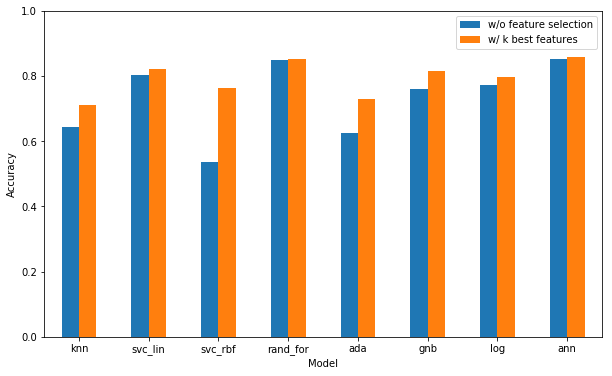

In [6]:
%matplotlib inline
ax = df2.drop(['bestK', 'holdout_bestK_acc', 'valid_bestK_acc'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1))
l = ax.legend(labels=['w/o feature selection', 'w/ k best features'])
fig = ax.get_figure()
fig.savefig('images/feature_subset_acc_mi.png')

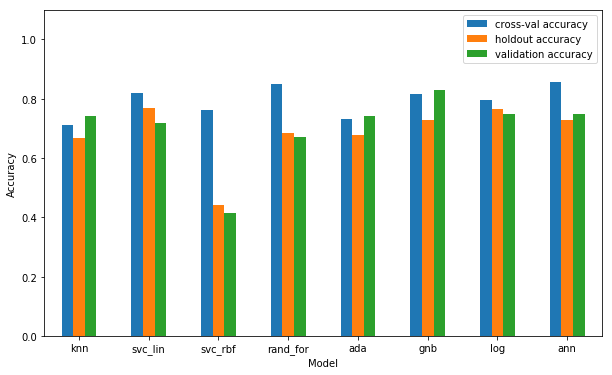

In [8]:
%matplotlib inline
ax = df2.drop(['mean_cv_acc', 'bestK'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1.1))
l = ax.legend(labels=['cross-val accuracy','holdout accuracy', 'validation accuracy'])
fig = ax.get_figure()
fig.savefig('images/fss_validation_mi.png')

## NOTE:
We really shouldn't be considering the holdout and validation data when determining which **k** to choose, since that would mean our final model would be influenced by our holdout/valifation data and therefor we couldn't reliably say that the model generalizes to unseen data.  I plot it here to 
1. Show that the accuracy with the validation/holdout data is consistent with training data
1. When it is not consistent, it suggests that the models may be overfitting the training data and we could improve that by adjusting the hyperparameters of those models (svc_rbf, rand_for, ann) or simpling waiting until we get to the optimization stage of the workflow

## Bonus: Recursive Feature Elimination with Cross Validation
This method only works with models that have a *_coef* or *_feature_importance* field.

---------------------------
knn
Cannot perform Recursive Feature Elimination on this model
---------------------------
svc_lin
Optimal number of features : 37



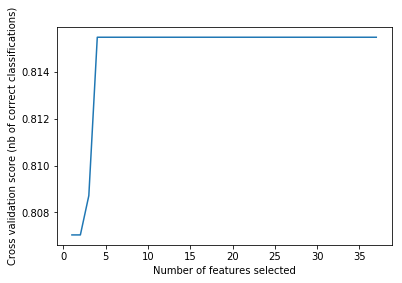

---------------------------
svc_rbf
Cannot perform Recursive Feature Elimination on this model
---------------------------
rand_for
Optimal number of features : 17



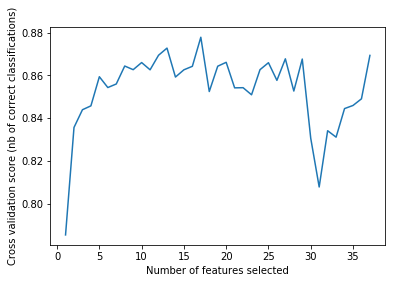

---------------------------
ada
Optimal number of features : 12



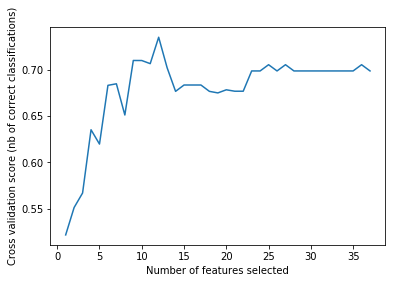

---------------------------
gnb
Cannot perform Recursive Feature Elimination on this model
---------------------------
log
Optimal number of features : 37



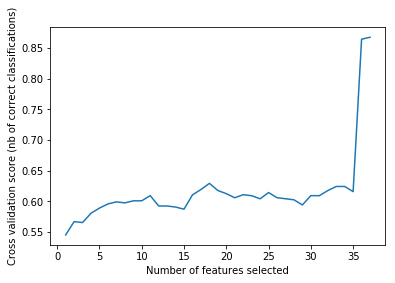

---------------------------
ann
Cannot perform Recursive Feature Elimination on this model


In [7]:
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV


classifiers = mu.get_baseline_models()
models = [clf['name'] for clf in classifiers]
df = pd.DataFrame(columns=['acc', 'acc_standardized', 'acc_standard_holdout', 'acc_standard_validation'], index=models)

for clf in classifiers:
    model = clf['model']
    name = clf['name']
    print('---------------------------')
    print(name)
    try:
        rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),
                  scoring='accuracy')
        rfecv.fit(X, y)

        print("Optimal number of features : %d" % rfecv.n_features_)
        print()

        # Plot number of features VS. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (nb of correct classifications)")
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        plt.show()
    except RuntimeError:
        print("Cannot perform Recursive Feature Elimination on this model")